# Lecture 4 Companion Notebook  
## Representations, Change of Basis, Nonlinear Compatibility, and Translation Symmetry

This notebook accompanies Lecture 4.

We will:
- Separate **domain actions** from **channel actions** (representations)
- Verify **change of basis**:  \tilde{\rho}(g) = Q\rho(g)Q^{-1}
- Show why **ReLU commutes with translation** but **breaks rotation**
- Specialize to **translation symmetry on a grid**
- Verify that **translation-equivariant linear maps are convolutions**
- Show how **pooling produces invariance**


In [6]:
import numpy as np
import matplotlib.pyplot as plt


In [7]:
def rel_error(a, b, eps=1e-12):
    return np.linalg.norm(a - b) / (np.linalg.norm(a) + np.linalg.norm(b) + eps)

def show_vec(v, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.axhline(0, linewidth=1)
    ax.axvline(0, linewidth=1)
    ax.arrow(0, 0, v[0], v[1], head_width=0.08, length_includes_head=True)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    if title:
        ax.set_title(title)
    return ax


## A. Representations = domain motion + channel mixing

We’ll work with:
- a domain action (translations on a 1D grid)
- a channel action (rotations acting on 2D vectors)

The general form is:

\[
(g\cdot x)(u) = \rho(g)\, x(g^{-1}u)
\]

- \(g^{-1}u\) moves the input location
- \(\rho(g)\) mixes the feature channels at that location


In [8]:
def shift_1d(x, t):
    """
    Circular shift of a 1D signal x by integer t.
    (Periodic boundary condition)
    """
    x = np.asarray(x)
    return np.roll(x, t)


In [9]:
def R(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s],
                     [s,  c]])

# quick sanity check
theta = np.pi/4
print(R(theta))


[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


## B. Change of basis in channel space

If we change channel coordinates by \(\tilde{x}(u) = Qx(u)\),
then the same geometric action is represented by:

\[
\tilde{\rho}(g) = Q\rho(g)Q^{-1}.
\]

We'll verify this numerically for a rotation representation.


In [10]:
np.random.seed(0)

theta = 0.7
rho = R(theta)

# random invertible Q
Q = np.random.randn(2, 2)
while abs(np.linalg.det(Q)) < 1e-2:
    Q = np.random.randn(2, 2)

rho_tilde = Q @ rho @ np.linalg.inv(Q)

v = np.array([1.2, -0.7])
v_tilde = Q @ v

lhs = rho_tilde @ v_tilde
rhs = Q @ (rho @ v)

print("Change-of-basis check rel error:", rel_error(lhs, rhs))


Change-of-basis check rel error: 7.09157312096203e-17


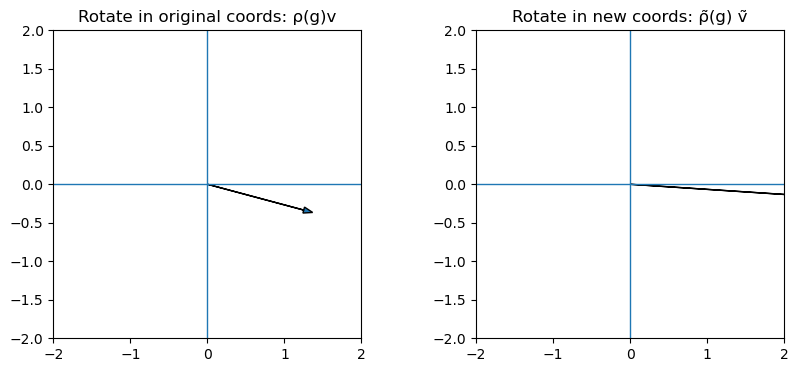

In [11]:
v = np.array([1.0, -1.0])
theta = np.pi/6
rho = R(theta)

# choose a nice Q: shear+scale
Q = np.array([[2.0, 0.6],
              [0.2, 1.2]])
rho_tilde = Q @ rho @ np.linalg.inv(Q)

fig, axs = plt.subplots(1, 2, figsize=(10,4))

show_vec(rho @ v, ax=axs[0], title="Rotate in original coords: ρ(g)v")
show_vec(rho_tilde @ (Q @ v), ax=axs[1], title="Rotate in new coords: ρ̃(g) ṽ")

plt.show()


## C. Nonlinearities and equivariance

A nonlinearity \(\sigma\) preserves equivariance if:

\[
\sigma(g\cdot x) = g\cdot \sigma(x).
\]

For translation on a grid (reindexing only), pointwise nonlinearities commute automatically.

For rotations mixing channels, componentwise nonlinearities like ReLU generally **do not** commute.


In [13]:
def relu(z):
    return np.maximum(0, z)


In [14]:
x = np.array([0.2, -1.0, 0.5, -0.3, 1.2])
t = 2

lhs = relu(shift_1d(x, t))            # σ(Tx)
rhs = shift_1d(relu(x), t)            # Tσ(x)

print("ReLU vs translation rel error:", rel_error(lhs, rhs))
print("lhs:", lhs)
print("rhs:", rhs)


ReLU vs translation rel error: 0.0
lhs: [0.  1.2 0.2 0.  0.5]
rhs: [0.  1.2 0.2 0.  0.5]


In [15]:
v = np.array([1.0, -1.0])
theta = np.pi/2
rot = R(theta)

lhs = relu(rot @ v)          # σ(Rv)
rhs = rot @ relu(v)          # Rσ(v)

print("v:", v)
print("Rv:", rot @ v)
print("σ(Rv):", lhs)
print("σ(v):", relu(v))
print("Rσ(v):", rhs)
print("ReLU vs rotation rel error:", rel_error(lhs, rhs))


v: [ 1. -1.]
Rv: [1. 1.]
σ(Rv): [1. 1.]
σ(v): [1. 0.]
Rσ(v): [6.123234e-17 1.000000e+00]
ReLU vs rotation rel error: 0.41421356237292345


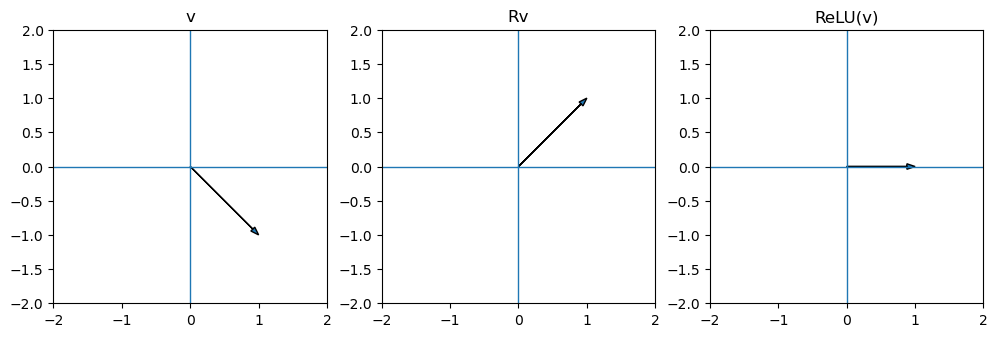

In [16]:
v = np.array([1.0, -1.0])
theta = np.pi/2
rot = R(theta)

fig, axs = plt.subplots(1, 3, figsize=(12,4))
show_vec(v, ax=axs[0], title="v")
show_vec(rot @ v, ax=axs[1], title="Rv")
show_vec(relu(v), ax=axs[2], title="ReLU(v)")

plt.show()


## D. Translation symmetry on a discrete grid

We now focus on translations on a 1D periodic grid (a ring).
This makes the group action exact and avoids boundary issues.

Translation equivariance means:
\[
f(T_t x) = T_t f(x).
\]

We’ll verify this for linear maps.


In [17]:
def shift_matrix(n, t):
    """n×n matrix implementing circular shift by t."""
    T = np.zeros((n, n))
    for i in range(n):
        T[(i + t) % n, i] = 1.0
    return T

n = 8
T1 = shift_matrix(n, 1)
print("T1:\n", T1)


T1:
 [[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


## E. Translation-equivariant linear maps are convolutions

We will:
1) Generate a random linear map W
2) Measure how far it is from commuting with translations:  WT - TW
3) Project it onto the commuting subspace by group-averaging:
\[
\Pi(W) = \frac{1}{|G|}\sum_{t} T_t W T_t^{-1}.
\]
4) Show the result is **circulant** (convolution on a ring).


In [18]:
def commutation_error(W, T):
    return np.linalg.norm(W @ T - T @ W)

n = 16
W = np.random.randn(n, n)

errs = []
for t in range(n):
    Tt = shift_matrix(n, t)
    errs.append(commutation_error(W, Tt))

print("Random W: mean commutation error:", np.mean(errs))
print("Random W: min/max:", np.min(errs), np.max(errs))


Random W: mean commutation error: 20.682681096608484
Random W: min/max: 0.0 22.990791665770942


In [19]:
def project_to_translation_equivariant(W):
    n = W.shape[0]
    Wp = np.zeros_like(W, dtype=float)
    for t in range(n):
        Tt = shift_matrix(n, t)
        # Tt^{-1} = T_{-t} for circular shifts
        Tinv = shift_matrix(n, -t)
        Wp += Tt @ W @ Tinv
    return Wp / n

Wp = project_to_translation_equivariant(W)

errs_p = []
for t in range(n):
    Tt = shift_matrix(n, t)
    errs_p.append(commutation_error(Wp, Tt))

print("Projected W: mean commutation error:", np.mean(errs_p))
print("Projected W: min/max:", np.min(errs_p), np.max(errs_p))


Projected W: mean commutation error: 7.819162744807211e-16
Projected W: min/max: 0.0 9.072189161023294e-16


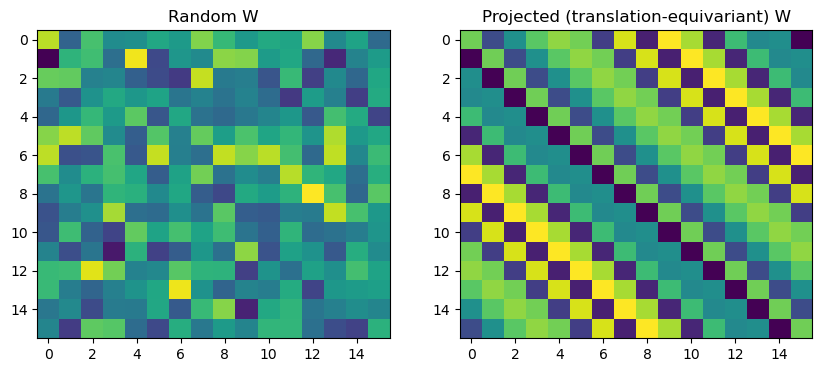

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].imshow(W, aspect="auto")
axs[0].set_title("Random W")
axs[1].imshow(Wp, aspect="auto")
axs[1].set_title("Projected (translation-equivariant) W")
plt.show()


In [21]:
def delta(n, idx=0):
    x = np.zeros(n)
    x[idx] = 1.0
    return x

h = Wp @ delta(n, 0)  # impulse response
print("Impulse response h (kernel on the ring):\n", np.round(h, 3))


Impulse response h (kernel on the ring):
 [ 0.197 -0.444 -0.04  -0.06   0.116 -0.357  0.269  0.375 -0.371  0.325
 -0.291  0.201  0.24   0.164 -0.032 -0.253]


In [22]:
x = np.random.randn(n)
t = 5

y1 = Wp @ shift_1d(x, t)
y2 = shift_1d(Wp @ x, t)

print("Equivariance check (Wp):", rel_error(y1, y2))


Equivariance check (Wp): 1.1870511991719524e-16
